# GDROM

## Part 1: Preparation
### 1.1 Preparing Python packages

In [1]:
# import necessary packages for HMDT model
from hmmlearn import hmm_DT 
from hmmlearn import base_DT 
from hmmlearn.hmm_DT import GaussianHMM as GHMM
import sklearn
from sklearn.tree import DecisionTreeRegressor
import importlib

In [2]:
# import other necessary packages
from sklearn import tree
from sklearn.model_selection import GridSearchCV

import pandas as pd
import numpy as np
import math
import copy

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
# functions to save and read binary files
import pathlib
import pickle
def pickle_save(name,var):
    file_Name = name
    abspath = pathlib.Path(file_Name).absolute()
    
    # open the file for writing
    
    fileObject = open(abspath,'wb')
    
    # this writes the object tweets to the file '
    pickle.dump(var,fileObject)  
    
    # here we close the fileObjec
    
    fileObject.close()
    return None

def pickle_read(name):
    file_Name = name  

    fileObject = open(file_Name,'rb')     
  
    var = pickle.load(fileObject)
    fileObject.close()
    
    return var

### 1.2 Preparing Data
For each reservoir, we need to prepare a data frame with 6 columns, including 'Time', 'Storage', 'NetInflow', 'Release', 'DOY' (Day of Year), 'PDSI' (Palmer Drought Severity Index). Outliers should be removed from the data frame. Notebly, 'Storage' should represent the daily initial storage, while sometimes the acquired storage data is recorded at the end of each day. In this case, the storage time series need to be shifted by one time step (i.e., one day) to represent the intial storage for next time period. In addition, given that inflow data is missed for a large portion of reservoirs in our dataset, we calculate the "net inflow" ($netI_t$) based on water balance (eq.1) as the inflow volume to the reservoir. Specifically, the mass balance equation is:
$$S_{t+1} = S_t + netI_t - R_t \tag{1}$$ 
$$netI_t = I_t+G_t-L_t \tag{2}$$
where, $S_t$ is the initial storage at day $t$; $I_t$ is the total inflow to the reservoir during day $t$; $R_t$ is the water volume released during day $t$; $G_t$ represents the total water volume gained other than inflow, such as the precipitation and recharge from adjacent aquifers; $L_t$ denotes the total loss of water from the reservoir during day $t$, such as the loss through seepage and evaporation. When GDROM is coupled with hydrological models for hypothetical scenarios, $netI_t$ could be obtained using eq.2.

Finally, for each reservoir, 'NetInflow', 'Release', 'Storage' should be normalized by the maximum historical storage during the observation period, which scales the values to enable comparing the extracted operation modules among different reservoirs, regardless of the reservoir size. In addition, the normalization reduces the time required for hyperparameter tuning, especially the minimum impurity decrease, of which the range of candidate values is considerably decreased. Note that the minimum storage should be extratced from the historical reservoir operation records (or provided based on external infomration), which is used in the GDROM to check and correct the outliers of the simulated storage.

In [4]:
# load original data
# example: Echo Reservoir (ID:449) in Upper Colorado River basin
from os import listdir
from os.path import isfile, join
import re

path = r"...\Original"
files = [join(path, f) for f in listdir(path) if isfile(join(path, f))]
pattern  = re.compile(r"(?<=Original\\)[\d]+(?=.)")

for f in files[:]:
    res = re.search(pattern, f)
    print(res[0])
    data = pd.read_csv(f,engine = 'python',index_col=False)
    print(data.head())
    min_storage = min(data['Storage'])
    print("historical minimum storage: " + str(min_storage))
    

449
       Time   Storage  NetInflow   Release  DOY  PDSI
0  6/5/1990  0.854815   0.007098  0.010731  156 -4.96
1  6/6/1990  0.851181   0.007098  0.010731  157 -4.96
2  6/7/1990  0.847548   0.007712  0.011332  158 -4.96
3  6/8/1990  0.843928   0.005895  0.011332  159 -4.96
4  6/9/1990  0.838491   0.005908  0.011332  160 -4.96
historical minimum storage: 0.045639439000000004


### 1.2.1 Data Segmentation

Since the observed operation (i.e., daily release series) is assumed to follow the Markov process, the training samples must be continuous, while multiple continuous pieces are also acceptable. Thus, we detect and remove the missing dates and break the operation record into multiple continuous pieces from the missing data points. Note that the pieces without sufficient observations cannot capture the latent temporal dependencies of the release decisions, and thus only pieces with more than 100 continuous observations are retained for training. The segmented continuous time series are treated as independent samples during model training.

In [5]:
def segmentation(df, name, basefolder):
    thres = 100
    n_rec = len(df)
    n = 0
    k = 0
    for index, row in df.iterrows():
        if index == n_rec - 1:
            break
        if(df['Time'][index] + timedelta(days = 1) == df['Time'][index + 1]):
            n = n + 1
        else:
            df_temp = df.iloc[:n+1,:]
            df = df.iloc[n+1:,:]
            if(len(df_temp) > thres):
                df_temp.to_csv(basefolder+name+'_'+str(k)+'.csv', index=False)
                print(name+'_'+str(k))
                k = k + 1
            n = 0
            
    if (len(df) > thres):
        df.to_csv(basefolder+name+'_'+str(k)+'.csv', index = False)
        print(name+'_'+str(k))

In [6]:
# to segment data series to keep only continuous records longer than 100 days
from datetime import timedelta
basefolder = "...\\Continuous\\"

for f in files[:]:
    print('---------')
    name = re.search(pattern, f)[0]
    print(name)
    data = pd.read_csv(f, engine = 'python', index_col=False)
    data['Time'] = pd.to_datetime(data['Time'])
    
    segmentation(data, name, basefolder)
    print("finish!")



---------
449
449_0
449_1
449_2
finish!


### 1.2.2 Splitting Training-Validation-Testing Data
The GDROM is derived from a two-step method, including extraction of representative modules (by HM-DT) and  determination of  module application conditions (by CART). In the model training phase for a reservoir, 80% of the operation data is used for model training, and the remaining 20% of the data is held out for the final testing. However, the “training” data is further split into training and validation sets following the same '80/20′ principle. Thus, the final train-validation-test ratio becomes 64%-16%-20%. Specifically, 64% of the data is used to train HM-DT models with different hyperparameters, and then the model performance is tested on 16% of the data to determine the best hyperparameters since HM-DT model requires manual hyper-parameters tuning. For CART model, however, we can implement the k-fold cross-validation technique to automatically determine the hyperparameters. Hence, 80% of the data is used for CART model training with 5-fold cross-validation, which implies that 64% of the data is used for training and 16% for validation.

In [7]:
# load continuous data
path = r"...\Continuous"
files = [join(path, f) for f in listdir(path) if isfile(join(path, f))]
pattern  = re.compile(r"(?<=Continuous\\)[\d]+(?=_)")

# sort files
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split(r'(\d+)', text) ]
files.sort(key=natural_keys)

# folders to save training, validation and testing data
tr_base1 = "...\\Training\\"
tr_base2 = "...\\Training_HMDT\\"
val_base = "...\\Validation_HMDT\\"
te_base = "...\\Testing\\"
        
lengths = []
data_features = pd.DataFrame({'Time':[], 'Storage':[], 'NetInflow':[],'Release':[], 'DOY':[], 'PDSI':[]})

# example: Echo Reservoir (ID:449) in Upper Colorado River basin
current_name = "449"

for f in files[:]:
    res = re.search(pattern, f)
    data = pd.read_csv(f,engine = 'python',index_col=False)
    data['Time'] = pd.to_datetime(data['Time'])

    if res[0] == current_name:
        data_features = data_features.append(data[['Time','Storage','NetInflow','Release','DOY','PDSI']])
        lengths.append(len(data))
    
    if res[0] == current_name and f == files[-1]:
        print(current_name)
        print(sum(lengths))

        tr_len1 = int(0.8 * sum(lengths))
        tr_len2 = int(0.64 * sum(lengths))
        data_train1 = data_features.iloc[0:tr_len1,:]
        data_train2 = data_features.iloc[0:tr_len2,:]
        data_val = data_features.iloc[tr_len2:tr_len1,:]
        data_test = data_features.iloc[tr_len1:,:]
        
        data_train1.reset_index(inplace=True, drop=True)
        data_train2.reset_index(inplace=True, drop=True)
        data_val.reset_index(inplace=True, drop=True)
        data_test.reset_index(inplace=True, drop=True)
        
        segmentation(data_train1, current_name, tr_base1)
        segmentation(data_train2, current_name, tr_base2)
        segmentation(data_val, current_name, val_base)
        segmentation(data_test, current_name, te_base)
        
        print("finish!")



449
10677
449_0
449_1
449_0
449_1
449_0
449_0
finish!


## Part 2: Procedures for developing the GDROM
### 2.1 Training HM-DT Model and Determining Hyperparameters
For GDROM, the HM-DT model is used to derive the representative modules. HM-DT model has two important hyperparameters: the number of hidden states (K) and the minimum decrease in impurity for the decision tree to stop growth during training (ITS_min), which is a parameter that is used to control the overfitting of a decision tree by avoiding node splits with the minimal increase in predictive accuracy. In the  training stage, 30  different combinations of  the  two  hyper-parameters are designed, each of which results in one set of representative operation modules. Regarding the model performance, a larger K and a smaller ITS_min will always yield the better performance. However, there can be an overfitting issue (which is similar to the case of a polynomial regression with a large number of items). To resolve this problem, the 30 sets of representative operation modules are tested on the validation data, and the one with the best performance NSE is chosen for final testing stage.

In [8]:
def train_hmdt(name, data_features, impurity, saving_folder):
    print(name)
    ITS_min = pow(10,-impurity)
    print(ITS_min)
    
    O = data_features['Release'].values.reshape(-1, 1)
    F = data_features[['NetInflow','Storage']].values

    # create decision tree model to be used as the decision model for reservoir operation
    treemodel = DecisionTreeRegressor(min_impurity_decrease = ITS_min, random_state = 41, max_depth = 15, min_samples_leaf=10)

    treemodel0 = copy.deepcopy(treemodel)
    treemodel0.fit(F,O)
    pickle_save(saving_folder+name + '_model_e-'+str(impurity)+'.model',treemodel0)

    # load hmm model
    importlib.reload(hmm_DT)
    importlib.reload(base_DT)
    GHMM = hmm_DT.GaussianHMM

    # fit models under different numbers (from 2 to 10) of hidden states, will be used to determine the best number of hidden states
    av_tr = []
    for i in range(2,11):
        model = GHMM(treemodel,relax = "all", n_components=i, verbose = True, n_iter = 200, trials = 10)
        model.fit(O,F,lengths = lengths)
        model = model.best_model
        pickle_save(saving_folder+name + '_model_e-'+str(impurity)+'_'+str(i)+'.model',model)
        print (name + "_finished model" + str(i))
        print(np.trace(model.transmat_)/i)
        av_tr.append(np.trace(model.transmat_)/i)
    

In [ ]:
##########################
# Training HM-DT model
# Running this section may take 2-3 minutes for a reservoir

# load training data for HM-DT model
path = r"...\Training_HMDT"
files = [join(path, f) for f in listdir(path) if isfile(join(path, f))]
files.sort(key=natural_keys)
pattern  = re.compile(r"(?<=Training_HMDT\\)[\d]+(?=_)")

hmdt_folder = "...\\HMDT_model\\"

lengths = []
data_features = pd.DataFrame({'Time':[], 'Storage':[], 'NetInflow':[],'Release':[], 'DOY':[], 'PDSI':[]})

# example: Echo Reservoir (ID:449) in Upper Colorado River basin
current_name = "449"

for f in files[:]:
    res = re.search(pattern, f)
    data = pd.read_csv(f,engine = 'python',index_col=False)
    data['Time'] = pd.to_datetime(data['Time'])

    if res[0] == current_name:
        data_features = data_features.append(data[['Time','Storage','NetInflow','Release','DOY','PDSI']])
        lengths.append(len(data))
    
    if res[0] == current_name and f == files[-1]:
        print(current_name)
        print(sum(lengths))
        
        for impurity in [6, 7, 8]:
            train_hmdt(current_name, data_features, impurity, hmdt_folder)



In [10]:
def validate_hmdt(name, data_features, impurity, hmdt_folder):
    O = data_features['Release'].values.reshape(-1, 1)
    F = data_features[['NetInflow','Storage']].values
    
    treemodel = pickle_read(hmdt_folder+name + '_model_e-'+str(impurity)+'.model')
    y = treemodel.predict(F)
    errors1 = data_features['Release'].values - y
    nse = [1 - np.sum((data_features['Release']-y)**2)/np.sum((data_features['Release']-np.mean(data_features['Release']))**2)]

    for i in range(2, 11):
        model = pickle_read(hmdt_folder+current_name +'_model_e-'+str(impurity)+'_' + str(i) + '.model')
        model.transmat_[np.sum(model.transmat_, axis=1) == 0] = 1 / i
        logprob, state_sequence = model.decode(O, F)
        result = np.zeros(data_features['Release'].values.shape)
        for j in range(i):
            if any(state_sequence == j):
                result[state_sequence == j] = model.model[j].predict(F[state_sequence == j])

        nse.append(1 - np.sum((data_features['Release']-result)**2)/np.sum((data_features['Release']-np.mean(data_features['Release']))**2))

    print("NSE under 1-10 hidden states when ITS_min=E-0"+str(impurity))
    print(nse)
    return nse


449
1708
NSE under 1-10 hidden states when ITS_min=E-06
[0.6128896087390558, 0.6371867282179461, 0.8479988282922526, 0.8914901459784739, 0.9567253795409666, 0.9178324790734614, 0.9193074881737752, 0.9269668715976768, 0.9503623981034585, 0.9247825115605933]
NSE under 1-10 hidden states when ITS_min=E-07
[0.6406727324425529, 0.6246109991551674, 0.8496815294233822, 0.9135560622479896, 0.9284517851140551, 0.9354550979277787, 0.9141222569308862, 0.9292338519808645, 0.9210319352502908, 0.904069267636801]
NSE under 1-10 hidden states when ITS_min=E-08
[0.5912689082786728, 0.5536447145973075, 0.8188946425053294, 0.8635319137344736, 0.8951153030725212, 0.9111593046254236, 0.9283354750212366, 0.9233997918256321, 0.9088950248720314, 0.9327521435775872]


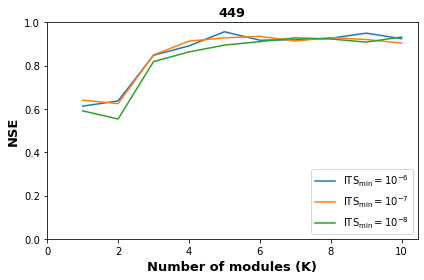

In [11]:
##########################
# Determining the best hyperparameters for HM-DT model

# load data
# remember to change the path to plot results for validation data
path = r"...\Validation_HMDT"
files = [join(path, f) for f in listdir(path) if isfile(join(path, f))]
files.sort(key=natural_keys)
pattern  = re.compile(r"(?<=Validation_HMDT\\)[\d]+(?=_)")

lengths = []
data_features = pd.DataFrame({'Time':[], 'Storage':[], 'NetInflow':[],'Release':[], 'DOY':[], 'PDSI':[]})

# example: Echo Reservoir (ID:449) in Upper Colorado River basin
current_name = "449"

for f in files[:]:
    res = re.search(pattern, f)
    data = pd.read_csv(f,engine = 'python',index_col=False)
    data['Time'] = pd.to_datetime(data['Time'])

    if res[0] == current_name:
        data_features = data_features.append(data[['Time','Storage','NetInflow','Release','DOY','PDSI']])
        lengths.append(len(data))
    
    if res[0] == current_name and f == files[-1]:
        print(current_name)
        print(sum(lengths))
        
        nse6 = validate_hmdt(current_name, data_features, 6, hmdt_folder)
        nse7 = validate_hmdt(current_name, data_features, 7, hmdt_folder)
        nse8 = validate_hmdt(current_name, data_features, 8, hmdt_folder)
            
        # plot of mse vs. number of models
        fontsize = 13
        plt.plot(range(1, 11), nse6, label='$\mathregular{ITS_{min} = 10^{-6}}$')
        plt.plot(range(1, 11), nse7, label='$\mathregular{ITS_{min} = 10^{-7}}$')
        plt.plot(range(1, 11), nse8, label='$\mathregular{ITS_{min} = 10^{-8}}$')
        plt.xlabel('Number of modules (K)',fontsize=fontsize, fontweight='black')
        plt.ylabel('NSE', fontsize=fontsize, fontweight='black')
        plt.ylim(0,1)
        plt.title(current_name,fontsize=fontsize, fontweight='black')
        plt.legend(loc='lower right',bbox_to_anchor=(1, 0) )
        plt.tight_layout()
        plt.xticks(np.arange(0,11,step=2))
        #plt.savefig(current_name+'nse_validation.png', dpi=400)
        plt.show()


Based on figure above, the best combination of hyperparameters is K=3 and ITS_min=$10^{-7}$ for Echo Reservoir (ID:449). The values of K and ITS_min are determined during the HM-DT validation step for each study reservoir, while these values might need some refinement for running a GDROM. With similar accuracy, it's recommended to choose a small K to reduce the complexity for CART.

It is noticed that for some reservoirs, the NSE values do not change significantly with K, indicating that one operation module can describe the major operation rules.
 

### 2.2 Training CART Model
For GDROM, the classification tree model (i.e., CART model) is used to determine the application conditions for representative modules. The input variables of the the classification model are  inflow, storage, PDSI, and  DOY. For  each  reservoir, the operation modules derived by the HM-DT model are numbered from 0 to K-1, referred to as module ID. Moreover, the module ID is the target variable (i.e.,  the  output) of the module classification model. To ensure the best performance, the 5-fold cross-validation technique is adopted in the training process.

In [12]:
##########################
# Training CART model

# load training data for CART model
path = r"...\Training"
files = [join(path, f) for f in listdir(path) if isfile(join(path, f))]
files.sort(key=natural_keys)
pattern  = re.compile(r"(?<=Training\\)[\d]+(?=_)")

lengths = []
data_features = pd.DataFrame({'Time':[], 'Storage':[], 'NetInflow':[],'Release':[], 'DOY':[], 'PDSI':[]})

# example: Echo Reservoir (ID:449) in Upper Colorado River basin
current_name = "449"
best_num_state = 3
best_its = 7

for f in files[:]:
    res = re.search(pattern, f)
    data = pd.read_csv(f,engine = 'python',index_col=False)
    data['Time'] = pd.to_datetime(data['Time'])

    if res[0] == current_name:
        data_features = data_features.append(data[['Time','Storage','NetInflow','Release','DOY','PDSI']])
        lengths.append(len(data))
    
    if res[0] == current_name and f == files[-1]:
        print(current_name)
        print(sum(lengths))
        O = data_features['Release'].values.reshape(-1, 1)
        F = data_features[['NetInflow','Storage']].values  
        
        ############
        # read the model with the best number of states
        n_state = best_num_state
        its = best_its
        model = pickle_read(hmdt_folder+current_name+'_model_e-'+str(its)+'_'+str(n_state)+'.model')
        
        # decode HMDT
        model.transmat_[np.sum(model.transmat_, axis=1) == 0] = 1 / n_state
        logprob, state_sequence = model.decode(O, F)
        state_sequence = list(state_sequence)
        
        data_res = []
        data_total = copy.deepcopy(data_features)
        data_res = data_total[:]
        print(len(data_res))
        seq_res = []
        seq_res = state_sequence[:]
        print(len(seq_res))
        
        ############
        # prepare dataframe for CART
        data_features['seq_res'] = seq_res
        train = data_features[['Time','Storage','NetInflow','Release','DOY','PDSI','seq_res']].copy()
        
        train_y = train['seq_res'].values
        train_x = train[['NetInflow','Storage','PDSI','DOY']].values

        parameters = {'max_depth':[4,5,6,8,10], 'min_samples_split':[5,10,15,20], 'min_samples_leaf':[5,10,15,20]}
        DT0 = tree.DecisionTreeClassifier()
        clf = GridSearchCV(DT0, parameters)
        clf.fit(train_x, train_y)
        print(clf.best_score_)
        pickle_save(current_name + '_CT.model',clf.best_estimator_)
        print('Finished!')
        

        

449
8541
8541
8541
0.7464031172618306
Finished!


## Part 3: Using GDROM for release prediction
The GDROM for a particular reservoir comprises a set of modules (derived from HM-DT) and an associated module classification model for the application conditions of each module (derived from the CART). Thus, running a  GDROM is  to  run  CART with  pre-derived modules from HM-DT. The GDROM determines daily release in three steps:

First, the module ID for a day is determined by the classification model based on inflow, storage, PDSI, and DOY. 

Second, the selected module with an identification number (ID) is invoked to determine the release, following which the storage at the end of this day (i.e., the beginning storage for the next day) is computed based on water balance. 

Third, the storage capacity constraints are examined to check if the computed reservoir storage lies between the minimum and maximum storage (s_min,s_max). If a storage capacity constraint is violated with the predicted release, the release decision and the computed storage will be adjusted based on water balance. 

Since the measured storage is not available for prediction, the computed storage will be used as model inputs to a GDROM. That is, given the initial storage of the reservoir, the storage at the end of a time period is obtained according to the water balance relationship embedded in the GDROM. The estimated storage at the end of period t is used as an input to the GDROM at period t +1 .

It should be mentioned that when only one representative operation module (K =1) is derived by the HM-DT model for a reservoir, a single DT model can predict the release with acceptable accuracy and thus the module classification model is not required. 

In [13]:
#########################
# GDROM function (for K>=2)
# water balance equation embedded; storage capacity constraint embedded

def GDROM_predict(df, initial_s, hmdt, CT_model, min_s):
    result = np.zeros(df['NetInflow'].values.shape)
    state_sequence = []
    storage_tra = []
    
    df = df.reset_index()
    temp_s = initial_s
    
    # predict release
    for i, row in df.iterrows():
        row['Storage'] = temp_s
        storage_tra.append(temp_s)
        CT_input = df.loc[i,['NetInflow','PDSI','DOY']].values.tolist()
        CT_input.insert(1, row['Storage'])
        Module_id = CT_model.predict(np.array(CT_input).reshape(-1,4))
        state_sequence.append(Module_id[0])
        F = np.array(row[['NetInflow','Storage']].values).reshape(-1,2)
        result[i] = hmdt.model[Module_id[0]].predict(F)
        temp_s = row['Storage'] + row['NetInflow'] - result[i]
        if temp_s > 1:
            result[i] = row['Storage'] + row['NetInflow'] - 1
            temp_s = 1
            if result[i] > 1:
                result[i] = 1
        elif temp_s <= min_s:
            result[i] = row['Storage'] + row['NetInflow'] - min_s
            if result[i] < 0:
                result[i] = 0
            temp_s = min_s
    
    return state_sequence, result, storage_tra


In [14]:
#########################
# function to evaluate GDROM

def GDROM_performance(name, data_features, pre_R, pre_S):
    # computing NSE
    NSE = 1 - np.sum((data_features['Release']-pre_R)**2)/np.sum((data_features['Release']-np.mean(data_features['Release']))**2)
    NSE_S = 1 - np.sum((data_features['Storage']-pre_S)**2)/np.sum((data_features['Storage']-np.mean(data_features['Storage']))**2)
    print("NSE for release: "+str(NSE))
    print("NSE for storage: "+str(NSE_S))
    
    # computing PBIAS
    PB = np.sum(data_features['Release']-pre_R) / np.sum(data_features['Release'])
    PB_S = np.sum(data_features['Storage']-pre_S) / np.sum(data_features['Storage'])
    print("PBIAS for release: "+str(PB))
    print("PBIAS for storage: "+str(PB_S))

    # plotting simulations v.s. observations
    fontsize = 13
    f, ax = plt.subplots(2, 1, figsize=(7, 6), sharex=True)
    
    ax[0].set_title(name, fontsize=fontsize, fontweight='black')
    ax[0].plot(data_features['Time'], data_features['Release'], marker='', linestyle='-', color = 'darkblue',linewidth = 1)
    ax[0].plot(data_features['Time'],pre_R, marker='', linestyle='-', color = 'red',markersize=2, linewidth = 1)
    ax[0].set_ylabel('Release',fontsize=fontsize, fontweight='black')
    ax[0].tick_params(axis='x', labelsize=12)
    ax[0].tick_params(axis='y', labelsize=12)
        
    ax[1].plot(data_features['Time'], data_features['Storage'],marker='', linestyle='-', color = 'darkblue', linewidth = 1)
    ax[1].plot(data_features['Time'],pre_S, marker='', linestyle='-', color = 'red',markersize=2, linewidth = 1)
    ax[1].set_ylabel('Storage',fontsize=fontsize, fontweight='black')
    ax[1].set_xlabel('Time', fontsize=fontsize, fontweight='black')
    ax[1].tick_params(axis='x', labelsize=12)
    ax[1].tick_params(axis='y', labelsize=12)

    myFmt = mdates.DateFormatter('%Y')
    ax[1].xaxis.set_major_formatter(myFmt)
    ax[1].legend(['observed','simulated'], fontsize=fontsize, loc='upper center', markerscale=5, ncol=3, bbox_to_anchor=(0.5, -0.2))
    
    plt.tight_layout()
    #plt.savefig('test_' + name + '.png', dpi=400)
    plt.show()

E:\hmdt_code\Testing\449_0.csv
449
2135
NSE for release: 0.691889322452157
NSE for storage: 0.8127993320128378
PBIAS for release: -0.023684323525251266
PBIAS for storage: -0.008423843504517149


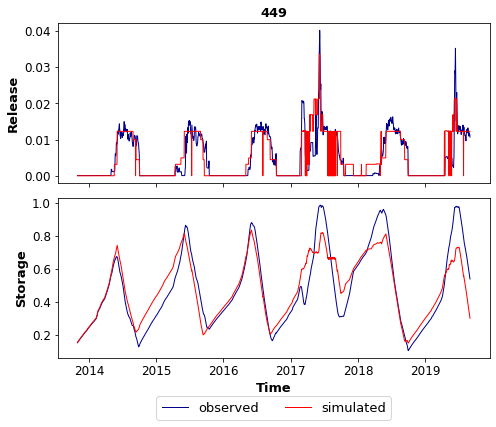

In [15]:
##########################
# GDROM

# load testing data (or training data) to check GDROM performance
path = r"...\Testing"
files = [join(path, f) for f in listdir(path) if isfile(join(path, f))]
files.sort(key=natural_keys)
pattern  = re.compile(r"(?<=Testing\\)[\d]+(?=_)")

lengths = []
data_features = pd.DataFrame({'Time':[], 'Storage':[], 'NetInflow':[],'Release':[], 'DOY':[], 'PDSI':[]})

# example: Echo Reservoir (ID:449) in Upper Colorado River basin
current_name = "449"
min_storage = 0.045639439000000004

# read the HMDT model with the best hyperparameters
#      Note: it's recommended to rename the selected HM-DT model and move it to a new folder if users have multiple reservoirs
best_num_state = 3
best_its = 7
hmdt = pickle_read(hmdt_folder+current_name+ '_model_e-'+str(best_its)+'_' + str(best_num_state) + '.model')
# read CART model
CT_model = pickle_read(current_name+'_CT.model')


# lists to save the predicted results
pre_R = [] # predicted release
pre_S = [] # predicted storage 
state_seq = [] # predicted module application sequence

for file in files[:]:
    print(file)
    res = re.search(pattern, file)
    data = pd.read_csv(file,engine = 'python',index_col=False)
    data['Time'] = pd.to_datetime(data['Time'])

    # prediction
    initial_s = data['Storage'].tolist()[0] # extracting the initial storage for each continuous data piece
    df_test = data[['Time','NetInflow','DOY','PDSI']].copy()
    state_seq0, pre_R0, pre_S0 = GDROM_predict(df_test, initial_s, hmdt, CT_model, min_storage)

    if res[0] == current_name:
        data_features = data_features.append(data[['Time','Storage','NetInflow','Release','DOY','PDSI']])
        lengths.append(len(data))
        state_seq.extend(state_seq0)
        pre_R.extend(pre_R0)
        pre_S.extend(pre_S0)
    
    if res[0] == current_name and file == files[-1]:
        print(current_name)
        print(sum(lengths))
        
        GDROM_performance(current_name, data_features, pre_R, pre_S)
